### 1. Calculate user and product embeddings

We calculate these embeddings simply by averaging all the reviews about the same product or written by the same user within the training set.

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

df = pd.read_csv('data/fine_food_reviews_with_embeddings_1k.csv', index_col=0)
df['embedding'] = df.embedding.apply(eval).apply(np.array)
X_train, X_test, y_train, y_test = train_test_split(df, df.Score, test_size = 0.2, random_state=42)

user_embeddings = X_train.groupby('UserId').embedding.apply(np.mean)
prod_embeddings = X_train.groupby('ProductId').embedding.apply(np.mean)
len(user_embeddings), len(prod_embeddings)


(577, 706)

We can see that most of the users and products appear within the 50k examples only once.

### 2. Evaluate the embeddings

To evaluate the recommendations, we look at the similarity of the user and product embeddings amongst the reviews in the unseen test set. We calculate the cosine distance between the user and product embeddings, which gives us a similarity score between 0 and 1. We then normalize the scores to be evenly split between 0 and 1, by calculating the percentile of the similarity score amongst all predicted scores.

In [3]:
from openai.embeddings_utils import cosine_similarity

# evaluate embeddings as recommendations on X_test
def evaluate_single_match(row):
    user_id = row.UserId
    product_id = row.ProductId
    try:
        user_embedding = user_embeddings[user_id]
        product_embedding = prod_embeddings[product_id]
        similarity = cosine_similarity(user_embedding, product_embedding)
        return similarity
    except Exception as e:
        return np.nan

X_test['cosine_similarity'] = X_test.apply(evaluate_single_match, axis=1)
X_test['percentile_cosine_similarity'] = X_test.cosine_similarity.rank(pct=True)


#### 2.1 Visualize cosine similarity by review score

We group the cosine similarity scores by the review score, and plot the distribution of cosine similarity scores for each review score.

Correlation between user & vector similarity percentile metric and review number of stars (score): 17.25%


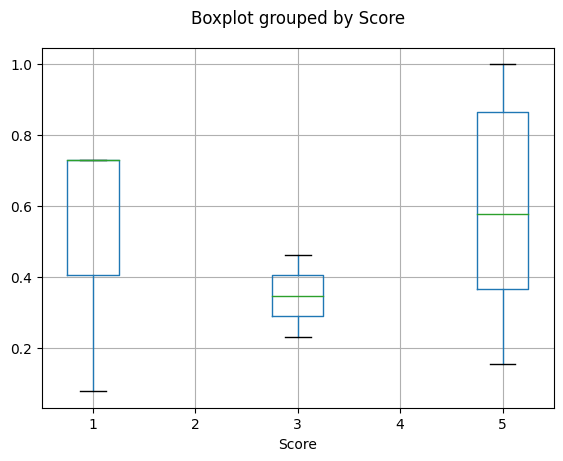

In [4]:
import matplotlib.pyplot as plt
import statsmodels.api as sm


correlation = X_test[['percentile_cosine_similarity', 'Score']].corr().values[0,1]
print('Correlation between user & vector similarity percentile metric and review number of stars (score): %.2f%%' % (100*correlation))

# boxplot of cosine similarity for each score
X_test.boxplot(column='percentile_cosine_similarity', by='Score')
plt.title('')
plt.show()
plt.close()

We can observe a weak trend, showing that the higher the similarity score between the user and the product embedding, the higher the review score. Therefore, the user and product embeddings can weakly predict the review score - even before the user receives the product!

Because this signal works in a different way than the more commonly used collaborative filtering, it can act as an additional feature to slightly improve the performance on existing problems.